In [1]:
import pandas as pd
import sys
import os
selected_categories = ["Nursing", "Nursing/other"]
# Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import importlib
import utils.event_extractor  

importlib.reload(utils.event_extractor)
from utils.event_extractor import EventExtractor  

import pandas as pd
import numpy as np

def get_quartiles(df, column):
    """
    Calculate the quartiles (Q1, Q2, Q3) for a given column in a DataFrame and return the quartile values along with the subset of rows between Q1 and Q2.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name for which to calculate quartiles.

    Returns:
        tuple: (q1, q2, q3, mid_df)
            q1 (float): 25th percentile value.
            q2 (float): Median (50th percentile) value.
            q3 (float): 75th percentile value.
            mid_df (pd.DataFrame): Subset of df where column values are between q1 and q2 (inclusive).
    """
    q1 = df[column].quantile(0.25)
    q2 = df[column].median()
    q3 = df[column].quantile(0.75)
    mid_df = df[(df[column]>=q1)&(df[column]<=q2)]
    num = len(mid_df)
    print(f"{column} Quartiles :")
    print(f"Q1 (25th percentile): {q1:.2f}")
    print(f"Q2 (Median):          {q2:.2f}")
    print(f"Q3 (75th percentile): {q3:.2f}")
    print(f"Number of rows in this range q1-q3: {num}")
    return q1,q2,q3,mid_df


/home/asusaiyah/projects/event_log_from_text/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Load the admissions data
admissions = pd.read_pickle("../data/ADMISSIONS.pkl")

# Calculate Length of Stay in days
admissions["LOS_DAYS"] = (admissions["DISCHTIME"] - admissions["ADMITTIME"]).dt.total_seconds() / (24 * 3600)

# stay_q1,stay_q2,stay_q3 = get_quartiles(admissions, "LOS_DAYS")





Valid, alive patients are those who have a valide DOB and do not have a DOD associated to them.



In [3]:

# Load the PATIENTS.pkl file
patients = pd.read_pickle("../data/PATIENTS.pkl")
notes = pd.read_pickle("../data/NOTEEVENTS.pkl")
notes['HADM_ID'] = notes['HADM_ID'].fillna(0).astype(int)
notes = notes[notes.ISERROR!=1]
date_cols = ['DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN']
patients[date_cols] = patients[date_cols].apply(pd.to_datetime, errors='coerce')

# Filter patients with no recorded death
alive_patients = patients[
    patients['DOD'].isna() &
    patients['DOD_HOSP'].isna() &
    patients['DOD_SSN'].isna()
]

print(f"Number of patients not known to have died: {len(alive_patients)}")
print(alive_patients.head())


valid_alive_patients = alive_patients
valid_alive_patients['DOB'].min()


Number of patients not known to have died: 30761
   ROW_ID  SUBJECT_ID GENDER        DOB DOD DOD_HOSP DOD_SSN  EXPIRE_FLAG
0     234         249      F 2075-03-13 NaT      NaT     NaT            0
2     236         251      M 2090-03-15 NaT      NaT     NaT            0
3     237         252      M 2078-03-06 NaT      NaT     NaT            0
4     238         253      F 2089-11-26 NaT      NaT     NaT            0
5     239         255      M 2109-08-05 NaT      NaT     NaT            0


Timestamp('1800-07-16 00:00:00')

In [4]:
from datetime import datetime
import numpy as np

def calculate_age(row):
    admit = row['ADMITTIME'].to_pydatetime()
    dob = row['DOB'].to_pydatetime()
    return (admit - dob).days / 365.25

subject_id_to_dob = {i:j for (i,j) in zip(valid_alive_patients["SUBJECT_ID"], valid_alive_patients["DOB"])}


notes_selected = notes[~notes.duplicated(subset=["HADM_ID","CATEGORY","CHARTTIME"],keep=False)]
notes_selected = notes_selected[notes_selected.HADM_ID.isin(admissions.HADM_ID) & notes_selected.CATEGORY.isin(selected_categories)]
grouped_notes = notes_selected[notes_selected.CATEGORY.isin(selected_categories)].groupby(['HADM_ID']).count()['TEXT'].reset_index().rename(columns={'TEXT': 'COUNT_TEXT'})
hadm_to_num_report = {i:j for (i,j) in zip(grouped_notes["HADM_ID"], grouped_notes["COUNT_TEXT"])}



admissions['DOB'] = admissions['SUBJECT_ID'].apply(lambda x: subject_id_to_dob.get(x, np.nan))
admissions['AGE'] = admissions.apply(calculate_age, axis=1)
admissions['NUM_REPORTS'] = admissions['HADM_ID'].apply(lambda x:hadm_to_num_report.get(x, np.nan))



In [ ]:
import numpy as np
admissions["rounded_LOS"] = admissions["LOS_DAYS"].apply(lambda x: np.floor(x))
admissions = admissions[(admissions["LOS_DAYS"]<=admissions["NUM_REPORTS"]) & (admissions["LOS_DAYS"]<=14) &(admissions["LOS_DAYS"]>=5) ]
admissions = admissions[admissions.AGE<200]
admissions = admissions[admissions.AGE>=18]
admissions.dropna(subset=["DOB","NUM_REPORTS"],inplace=True)
# numreports less than no of days of stay rounded floor -> eliminate
len(admissions)



1330

In [6]:

# notes_selected[notes_selected].sort_values(["HADM_ID","CHARTTIME"])

# notes_selected.to_excel("../exports/temporary_view.xlsx")
notes_selected = notes_selected[notes_selected.HADM_ID.isin(admissions.HADM_ID.unique()) & notes_selected.CATEGORY.isin(selected_categories)]
notes_selected.describe()


,ROW_ID,SUBJECT_ID,HADM_ID,CGID,ISERROR
count,1.305100e+04,13051.000000,13051.000000,13051.000000,0.0
mean,1.466871e+06,17185.582101,149492.458279,17804.079228,NaN
std,1.647852e+05,11453.918485,29000.958290,2300.041073,NaN
min,3.235530e+05,13.000000,100046.000000,14020.000000,NaN
25%,1.360976e+06,7735.000000,124050.000000,15654.000000,NaN
50%,1.482178e+06,17113.000000,150552.000000,17707.000000,NaN
75%,1.593146e+06,25544.000000,174342.000000,19907.000000,NaN
max,1.678758e+06,99322.000000,199866.000000,21570.000000,NaN


NUM_REPORTS_PER_DAY Quartiles :
Q1 (25th percentile): 1.17
Q2 (Median):          1.39
Q3 (75th percentile): 1.76
Number of rows in this range q1-q3: 332
1.5IQR+Q3=: 2.6431497339620336


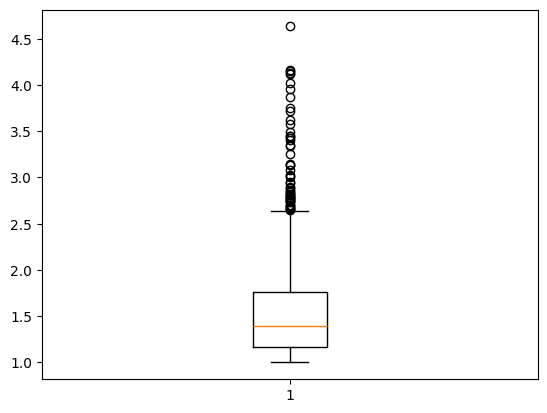

In [7]:
import matplotlib.pyplot as plt
admissions["NUM_REPORTS_PER_DAY"] = admissions["NUM_REPORTS"]/admissions["LOS_DAYS"]
plot_details = plt.boxplot(x=admissions["NUM_REPORTS_PER_DAY"])
q1,q2,q3,df_sel = get_quartiles(admissions,"NUM_REPORTS_PER_DAY")
print("1.5IQR+Q3=:",q3 + 1.5* (q3-q1))

In [8]:
admissions['NUM_REPORTS'].sum(), len(notes_selected)


(np.float64(13051.0), 13051)

In [9]:

13034 * 50/180000

3.6205555555555557

In [10]:
los_quartiles = get_quartiles(admissions, "LOS_DAYS")
n_report_quartiles = get_quartiles(admissions, "NUM_REPORTS")
age_quartiles = get_quartiles(admissions,"AGE")


LOS_DAYS Quartiles :
Q1 (25th percentile): 5.66
Q2 (Median):          6.22
Q3 (75th percentile): 7.00
Number of rows in this range q1-q3: 332
NUM_REPORTS Quartiles :
Q1 (25th percentile): 7.00
Q2 (Median):          9.00
Q3 (75th percentile): 11.00
Number of rows in this range q1-q3: 635
AGE Quartiles :
Q1 (25th percentile): 47.87
Q2 (Median):          59.60
Q3 (75th percentile): 71.70
Number of rows in this range q1-q3: 332


88.60780287474333


<Axes: >

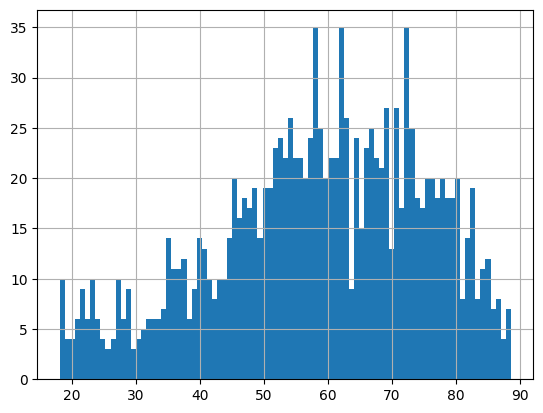

In [11]:
print(admissions['AGE'].max())
admissions['AGE'].hist(bins=89)

In [13]:
import os
import spacy

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
import utils.nlp_tools as nlp_tools
nlp_tools = importlib.reload(nlp_tools)
nlp = nlp_tools.TextLib("en_core_web_lg")

from resources.abbreviations import abbreviation_dict

# Load the English model (download if you haven't: python -m spacy download en_core_web_lg)


known_dict = {}
def extract_sentences(text):

    global known_dict
    if text in known_dict:
        return known_dict[text]
    else:
        text = nlp.replace_abbreviations(text,abbreviation_dict)
        text = nlp.remove_error_strings(text)
        sentences_raw = nlp.sentence_splitter(text,span=False)
        sentences = [sent['text'] for sent in sentences_raw]
        # headers = [sent['headers'] for sent in sentences_raw]
        known_dict[text] = sentences
    return sentences 

# filtered_reports_df = notes[(notes["HADM_ID"].isin(common_hadm)) & (notes["CATEGORY"].isin(selected_categories))]
filtered_reports_df = notes_selected
print(extract_sentences(filtered_reports_df['TEXT'].iloc[0]))
filtered_reports_df.loc[:,'Sentences'] = filtered_reports_df['TEXT'].apply(extract_sentences)


['Patient remains alert and oriented x3.', 'Maintaining bed rest, breathing\n   comfortable on O2 via NC @ 3l/min.', 'Desaturates to the 80\ns on room air.', 'Using IS well without need for encouragement.', 'Bilateral compression sleeves on and tolerating well.', 'Does have some\n   lower extremity edema, which has been present since admission to the\n   unit.', 'Fever, unknown origin (FUO, Hyperthermia, Pyrexia)', '   Patient\ns temp is being monitored q4hr/pro re nata.', 'Blood culture and urine\n   culture sent for analysis.', 'Unable to get sputum as patient.', 'has non\n   productive cough and effort is poor.', 'Mostly esophageal secretion.', '   Temperatures documented accordingly and antipyretic ordered pro re nata.', 'Lab\n   trends being monitored.', '   Remained afebrile overnight.', 'Urine culture negative for any organisms,\n   blood cultures are still pending.', 'WBCs now WNL.', '   Obtain sputum for culture if able.', 'Continue to watch for febrile\n   spikes.', 'Continue

In [14]:
import os
os.makedirs("../exports", exist_ok=True)
filtered_reports_df.to_pickle("../exports/filtered_patient_reports.pkl")